In [296]:
import numpy as np
from scipy.optimize import minimize_scalar
from typing import List, Tuple
import matplotlib.pyplot as plt

In [297]:
# Dữ liệu đầu vào
A = np.array([[1, 2],
              [-1, 3],
              [0.5, -2]])
b = np.array([0.1, 0.2, -0.1])

x0 = np.array([0.0, 0.0])

In [298]:
# Cài đặt hàm f(x) đề bài yêu cầu và gradient của hàm f(x)
f_eval_count = {"brent": 0, "parabola": 0}
current_mode = None
def f(x: np.ndarray) -> float:
    if current_mode is not None:
        f_eval_count[current_mode] += 1
    return np.log(np.sum(np.exp(A @ x + b)))

def grad_f(x: np.ndarray) -> np.ndarray:
    exps = np.exp(A @ x + b)
    return (exps @ A) / np.sum(exps)

In [299]:
# Cài đặt thuật toán theo phương pháp Parabol
def parabolic_interpolation(phi, t0 = 0, t1 = 1e-2, t2=1e-1, tol=1e-5, max_iter=100):
    for _ in range(max_iter):
        y0, y1, y2 = phi(t0), phi(t1), phi(t2)
        numerator = (t1 - t0)**2 * (y1 - y2) - (t1 - t2)**2 * (y1 - y0)
        demoniator = (t1 - t0) * (y1 - y2) - (t1 - t2) * (y1 - y2)
        if demoniator == 0:
            break
        t_min = t1 - 0.5 * numerator / demoniator
        if abs(t_min - t1) < tol:
            return t_min
        
        t0, t1, t2 = t1, t2, t_min
    
    return t1

def gradient_descent_parabolic(x0, epsilon=1e-5, max_iter=100):
    x = x0.copy()
    history = [x.copy()]
    for k in range(max_iter):
        g = grad_f(x)
        norm_g = np.linalg.norm(g)
        if norm_g < epsilon:
            print(f"Dừng tại vòng lặp {k} với ||∇f|| = {norm_g:.2e}")
            break
        phi = lambda t: f(x - t * g)
        t = parabolic_interpolation(phi)
        print(f"Vòng lặp {k:2d}: t_{k} = {t:.6f}, f(x_{k}) = {f(x):.6f}, ||∇f|| = {norm_g:.2e}")
        x = x - t * g
        history.append(x.copy())

    return x, history

In [300]:
# Cài đặt thuật toán theo phương pháp Brent
def gradient_descent_brent(x0, epsilon=1e-5, max_iter=100):
    x = x0.copy()
    history = [x.copy()]
    for k in range(max_iter):
        g = grad_f(x)
        norm_g = np.linalg.norm(g)
        if norm_g < epsilon:
            print(f"Dừng tại vòng lặp {k} với ||∇f|| = {norm_g:.2e}")
            break
        phi = lambda t: f(x - t * g)
        res = minimize_scalar(phi, method='brent')
        t = res.x
        print(f"Vòng lặp {k:2d}: t_{k} = {t:.6f}, f(x_{k}) = {f(x):.6f}, ||∇f|| = {norm_g:.2e}")
        x = x - t * g
        history.append(x.copy())

    return x, history

In [301]:
current_mode = "parabola"
x_parab, hist_prab = gradient_descent_parabolic(x0)
print(f"Nghiệm gần đúng theo phương pháp Parabol: {x_parab}. Số vòng lặp theo phương pháp Parabol: {len(hist_prab) - 1}")
print(f"Số lần gọi hàm f trong Parabol: {f_eval_count['parabola']}")

Vòng lặp  0: t_0 = 0.052688, f(x_0) = 1.172919, ||∇f|| = 1.26e+00
Vòng lặp  1: t_1 = 0.052898, f(x_1) = 1.098483, ||∇f|| = 9.74e-01
Vòng lặp  2: t_2 = 0.052343, f(x_2) = 1.054181, ||∇f|| = 7.46e-01
Vòng lặp  3: t_3 = 0.051186, f(x_3) = 1.028330, ||∇f|| = 5.81e-01
Vòng lặp  4: t_4 = 0.049716, f(x_4) = 1.012770, ||∇f|| = 4.69e-01
Vòng lặp  5: t_5 = 0.048314, f(x_5) = 1.002725, ||∇f|| = 3.96e-01
Vòng lặp  6: t_6 = 0.047102, f(x_6) = 0.995629, ||∇f|| = 3.49e-01
Vòng lặp  7: t_7 = 0.046208, f(x_7) = 0.990161, ||∇f|| = 3.19e-01
Vòng lặp  8: t_8 = 0.045597, f(x_8) = 0.985630, ||∇f|| = 2.99e-01
Vòng lặp  9: t_9 = 0.045200, f(x_9) = 0.981667, ||∇f|| = 2.85e-01
Vòng lặp 10: t_10 = 0.044948, f(x_10) = 0.978071, ||∇f|| = 2.75e-01
Vòng lặp 11: t_11 = 0.044791, f(x_11) = 0.974729, ||∇f|| = 2.67e-01
Vòng lặp 12: t_12 = 0.044695, f(x_12) = 0.971576, ||∇f|| = 2.61e-01
Vòng lặp 13: t_13 = 0.044635, f(x_13) = 0.968572, ||∇f|| = 2.55e-01
Vòng lặp 14: t_14 = 0.044598, f(x_14) = 0.965692, ||∇f|| = 2.50e-01


In [302]:
current_mode = "brent"
x_brent, hist_brent = gradient_descent_brent(x0)
print(f"Nghiệm gần đúng theo phương pháp Brent: {x_brent}. Số vòng lặp theo phương pháp Brent: {len(hist_brent) - 1}")
print(f"Số lần gọi hàm f trong Brent: {f_eval_count['brent']}")


Vòng lặp  0: t_0 = 0.210192, f(x_0) = 1.172919, ||∇f|| = 1.26e+00
Vòng lặp  1: t_1 = 1.299722, f(x_1) = 1.000887, ||∇f|| = 3.07e-01
Vòng lặp  2: t_2 = 0.189258, f(x_2) = 0.936326, ||∇f|| = 5.37e-01
Vòng lặp  3: t_3 = 1.222433, f(x_3) = 0.909142, ||∇f|| = 1.58e-01
Vòng lặp  4: t_4 = 0.185810, f(x_4) = 0.893522, ||∇f|| = 3.13e-01
Vòng lặp  5: t_5 = 1.203321, f(x_5) = 0.884463, ||∇f|| = 9.90e-02
Vòng lặp  6: t_6 = 0.184513, f(x_6) = 0.878491, ||∇f|| = 2.07e-01
Vòng lặp  7: t_7 = 1.195366, f(x_7) = 0.874573, ||∇f|| = 6.77e-02
Vòng lặp  8: t_8 = 0.183858, f(x_8) = 0.871809, ||∇f|| = 1.45e-01
Vòng lặp  9: t_9 = 1.191211, f(x_9) = 0.869872, ||∇f|| = 4.87e-02
Vòng lặp 10: t_10 = 0.183473, f(x_10) = 0.868450, ||∇f|| = 1.06e-01
Vòng lặp 11: t_11 = 1.188740, f(x_11) = 0.867413, ||∇f|| = 3.62e-02
Vòng lặp 12: t_12 = 0.183226, f(x_12) = 0.866632, ||∇f|| = 8.00e-02
Vòng lặp 13: t_13 = 1.187148, f(x_13) = 0.866047, ||∇f|| = 2.74e-02
Vòng lặp 14: t_14 = 0.183057, f(x_14) = 0.865598, ||∇f|| = 6.12e-02


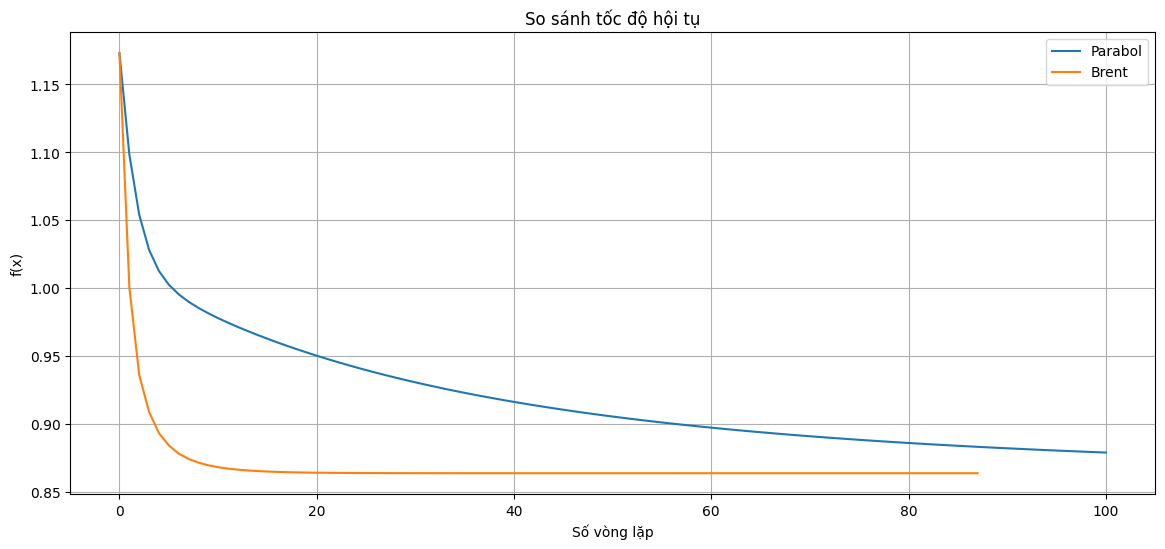

In [303]:
current_mode = None
loss_p = [f(x) for x in hist_prab]
loss_b = [f(x) for x in hist_brent]

plt.figure(figsize=(14, 6))
plt.plot(loss_p, label='Parabol')
plt.plot(loss_b, label='Brent')
plt.xlabel("Số vòng lặp")
plt.ylabel("f(x)")
plt.title("So sánh tốc độ hội tụ")
plt.legend()
plt.grid(True)
plt.show()